# Pima Indian Diabetes Prediction (with Model Reload)

Import some basic libraries.
* Pandas - provided data frames
* matplotlib.pyplot - plotting support

Use Magic %matplotlib to display graphics inline instead of in a popup window.


In [1]:
import pandas as pd                 # pandas is a dataframe library
import matplotlib.pyplot as plt      # matplotlib.pyplot plots data

%matplotlib inline

## Loading and Reviewing the Data

In [2]:
df = pd.read_csv("./data/pima-data.csv")

In [3]:
df.shape

(768, 10)

In [4]:
df.head(5)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True


In [5]:
df.tail(5)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
763,10,101,76,48,180,32.9,0.171,63,1.8912,False
764,2,122,70,27,0,36.8,0.340,27,1.0638,False
765,5,121,72,23,112,26.2,0.245,30,0.9062,False
766,1,126,60,0,0,30.1,0.349,47,0.0000,True
767,1,93,70,31,0,30.4,0.315,23,1.2214,False


### Definition of features
From the metadata on the data source we have the following definition of the features.

| Feature  | Description | Comments |
|--------------|-------------|--------|
| num_preg     | number of pregnancies         |
| glucose_conc | Plasma glucose concentration a 2 hours in an oral glucose tolerance test         |
| diastolic_bp | Diastolic blood pressure (mm Hg) |
| thickness | Triceps skin fold thickness (mm) |
|insulin | 2-Hour serum insulin (mu U/ml) |
| bmi |  Body mass index (weight in kg/(height in m)^2) |
| diab_pred |  Diabetes pedigree function |
| Age (years) | Age (years)|
| skin | ???? | What is this? |
| diabetes | Class variable (1=True, 0=False) |  Why is our data boolean (True/False)? |


## Check for null values

In [6]:
df.isnull().values.any()


False

### Correlated Feature Check

Helper function that displays correlation by color.  Red is most correlated, Blue least.

In [7]:
def plot_corr(df, size=11):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot

    Displays:
        matrix of correlation between columns.  Blue-cyan-yellow-red-darkred => less to more correlated
                                                0 ------------------>  1
                                                Expect a darkred line running from top left to bottom right
    """

    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks


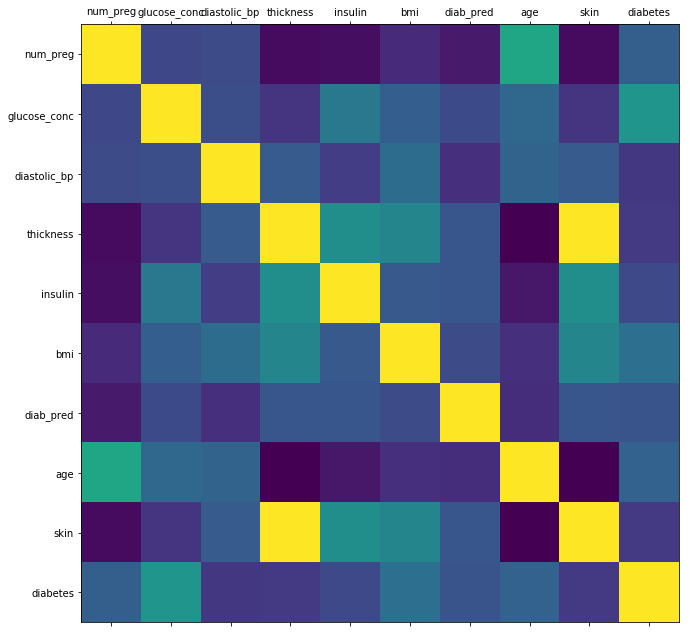

In [8]:
plot_corr(df)

In [9]:
df.corr()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
num_preg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,-0.081672,0.221898
glucose_conc,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.057328,0.466581
diastolic_bp,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.207371,0.065068
thickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,1.000000,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.436783,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.392573,0.292695
diab_pred,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.183928,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,-0.113970,0.238356
skin,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,1.000000,0.074752
diabetes,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,0.074752,1.000000


In [10]:
df.head(5)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True


The skin and thickness columns are correlated 1 to 1.  Dropping the skin column

In [11]:
del df['skin']

In [12]:
df.head(5)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,True
1,1,85,66,29,0,26.6,0.351,31,False
2,8,183,64,0,0,23.3,0.672,32,True
3,1,89,66,23,94,28.1,0.167,21,False
4,0,137,40,35,168,43.1,2.288,33,True


Check for additional correlations

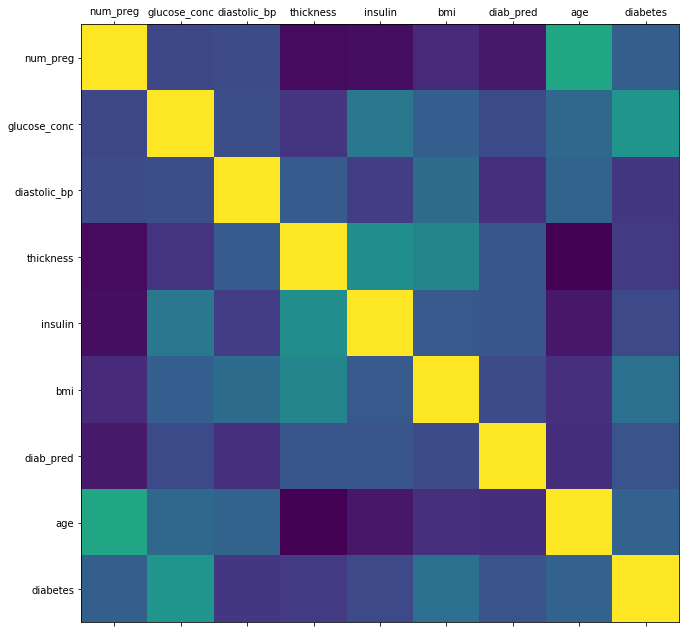

In [13]:
plot_corr(df)

The correlations look good.  There appear to be no coorelated columns.

## Mold Data

### Data Types

Inspect data types to see if there are any issues.  Data should be numeric.

In [14]:
df.head(5)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,True
1,1,85,66,29,0,26.6,0.351,31,False
2,8,183,64,0,0,23.3,0.672,32,True
3,1,89,66,23,94,28.1,0.167,21,False
4,0,137,40,35,168,43.1,2.288,33,True


Change diabetes from boolean to integer, True=1, False=0

In [15]:
diabetes_map = {True : 1, False : 0}
df['diabetes'] = df['diabetes'].map(diabetes_map)

Verify that the diabetes data type has been changed.

In [16]:
df.head(5)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Check for null values

In [17]:
df.isnull().values.any()

False

No obvious null values.

### Check class distribution 

Rare events are hard to predict

In [18]:
num_obs = len(df)
num_true = len(df.loc[df['diabetes'] == 1])
num_false = len(df.loc[df['diabetes'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  268 (34.90%)
Number of False cases: 500 (65.10%)


Good distribution of true and false cases.  No special work needed.

### Spliting the data 

70% for training, 30% for testing

In [19]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
feature_col_names = ['num_preg', 'glucose_conc', 'diastolic_bp', 'thickness', 'insulin', 'bmi', 'diab_pred', 'age']
predicted_class_names = ['diabetes']

X = df[feature_col_names].values     # predictor feature columns (8 X m)
y = df[predicted_class_names].values # predicted class (1=true, 0=false) column (1 X m)
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42) 
                            # test_size = 0.3 is 30%, 42 is the answer to everything

We check to ensure we have the the desired 70% train, 30% test split of the data

In [20]:
print("{0:0.2f}% in training set".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% in test set".format((len(X_test)/len(df.index)) * 100))

69.92% in training set
30.08% in test set


#### Verifying predicted value was split correctly

In [21]:
print("Original True  : {0} ({1:0.2f}%)".format(len(df.loc[df['diabetes'] == 1]), (len(df.loc[df['diabetes'] == 1])/len(df.index)) * 100.0))
print("Original False : {0} ({1:0.2f}%)".format(len(df.loc[df['diabetes'] == 0]), (len(df.loc[df['diabetes'] == 0])/len(df.index)) * 100.0))
print("")
print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
print("")
print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))


Original True  : 268 (34.90%)
Original False : 500 (65.10%)

Training True  : 188 (35.01%)
Training False : 349 (64.99%)

Test True      : 80 (34.63%)
Test False     : 151 (65.37%)


### Post-split Data Preparation

#### Hidden Missing Values

In [22]:
df.head()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Are these 0 values possible?

How many rows have have unexpected 0 values?

In [23]:
print("# rows in dataframe {0}".format(len(df)))
print("# rows missing glucose_conc: {0}".format(len(df.loc[df['glucose_conc'] == 0])))
print("# rows missing diastolic_bp: {0}".format(len(df.loc[df['diastolic_bp'] == 0])))
print("# rows missing thickness: {0}".format(len(df.loc[df['thickness'] == 0])))
print("# rows missing insulin: {0}".format(len(df.loc[df['insulin'] == 0])))
print("# rows missing bmi: {0}".format(len(df.loc[df['bmi'] == 0])))
print("# rows missing diab_pred: {0}".format(len(df.loc[df['diab_pred'] == 0])))
print("# rows missing age: {0}".format(len(df.loc[df['age'] == 0])))

# rows in dataframe 768
# rows missing glucose_conc: 5
# rows missing diastolic_bp: 35
# rows missing thickness: 227
# rows missing insulin: 374
# rows missing bmi: 11
# rows missing diab_pred: 0
# rows missing age: 0


#### Impute with the mean

In [24]:
# NEED CALLOUT MENTION CHANGE TO SIMPLEIMPUTER
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
#Impute with mean all 0 readings
#fill_0 = Imputer(missing_values=0, strategy="mean", axis=0)
fill_0 = SimpleImputer(missing_values=0, strategy="mean")
X_train = fill_0.fit_transform(X_train)
X_test = fill_0.fit_transform(X_test)

## Training Initial Algorithm - Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB

# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

### Performance on Training Data

In [26]:
# predict values using the training data
nb_predict_train = nb_model.predict(X_train)

# import the performance metrics library
from sklearn import metrics

# Accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, nb_predict_train)))
print()

Accuracy: 0.7542



### Performance on Testing Data

In [27]:
# predict values using the testing data
nb_predict_test = nb_model.predict(X_test)

from sklearn import metrics

# training metrics
print("nb_predict_test", nb_predict_test)
print ("y_test", y_test)
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_test)))


nb_predict_test [0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0
 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0
 0 0 0 0 0 0 0 0 0]
y_test [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [

#### Metrics

In [28]:
print("Confusion Matrix")
print("{0}".format(metrics.confusion_matrix(y_test, nb_predict_test)))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, nb_predict_test))


Confusion Matrix
[[118  33]
 [ 28  52]]

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       151
           1       0.61      0.65      0.63        80

   micro avg       0.74      0.74      0.74       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.74      0.74       231



## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=10)      # Create random forest object
rf_model.fit(X_train, y_train.ravel()) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Predict Training Data

In [30]:
rf_predict_train = rf_model.predict(X_train)
# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, rf_predict_train)))

Accuracy: 0.9870


### Predict Test Data

In [31]:
rf_predict_test = rf_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, rf_predict_test)))

Accuracy: 0.7100


In [32]:
print(metrics.confusion_matrix(y_test, rf_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, rf_predict_test))

[[121  30]
 [ 37  43]]

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       151
           1       0.59      0.54      0.56        80

   micro avg       0.71      0.71      0.71       231
   macro avg       0.68      0.67      0.67       231
weighted avg       0.70      0.71      0.71       231



## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

lr_model =LogisticRegression(C=0.7, random_state=42, solver='liblinear', max_iter=10000)
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_test)))
print(metrics.confusion_matrix(y_test, lr_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))

Accuracy: 0.7446
[[128  23]
 [ 36  44]]

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       151
           1       0.66      0.55      0.60        80

   micro avg       0.74      0.74      0.74       231
   macro avg       0.72      0.70      0.71       231
weighted avg       0.74      0.74      0.74       231



Setting regularization parameter

1st max value of 0.613 occured at C=1.400


Text(0, 0.5, 'recall score')

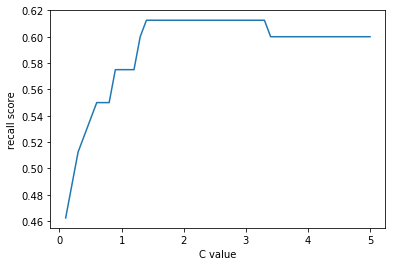

In [34]:
C_start = 0.1
C_end = 5
C_inc = 0.1

C_values, recall_scores = [], []

C_val = C_start
best_recall_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    lr_model_loop = LogisticRegression(C=C_val, random_state=42, solver='liblinear')
    lr_model_loop.fit(X_train, y_train.ravel())
    lr_predict_loop_test = lr_model_loop.predict(X_test)
    recall_score = metrics.recall_score(y_test, lr_predict_loop_test)
    recall_scores.append(recall_score)
    if (recall_score > best_recall_score):
        best_recall_score = recall_score
        best_lr_predict_test = lr_predict_loop_test
        
    C_val = C_val + C_inc

best_score_C_val = C_values[recall_scores.index(best_recall_score)]
print("1st max value of {0:.3f} occured at C={1:.3f}".format(best_recall_score, best_score_C_val))

%matplotlib inline 
plt.plot(C_values, recall_scores, "-")
plt.xlabel("C value")
plt.ylabel("recall score")


### Logisitic regression with class_weight='balanced'

1st max value of 0.738 occured at C=0.300


Text(0, 0.5, 'recall score')

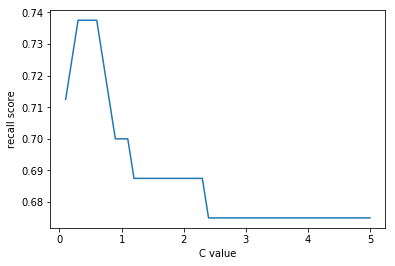

In [35]:
C_start = 0.1
C_end = 5
C_inc = 0.1

C_values, recall_scores = [], []

C_val = C_start
best_recall_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    lr_model_loop = LogisticRegression(C=C_val, class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000)
    lr_model_loop.fit(X_train, y_train.ravel())
    lr_predict_loop_test = lr_model_loop.predict(X_test)
    recall_score = metrics.recall_score(y_test, lr_predict_loop_test)
    recall_scores.append(recall_score)
    if (recall_score > best_recall_score):
        best_recall_score = recall_score
        best_lr_predict_test = lr_predict_loop_test
        
    C_val = C_val + C_inc

best_score_C_val = C_values[recall_scores.index(best_recall_score)]
print("1st max value of {0:.3f} occured at C={1:.3f}".format(best_recall_score, best_score_C_val))

%matplotlib inline 
plt.plot(C_values, recall_scores, "-")
plt.xlabel("C value")
plt.ylabel("recall score")

In [36]:
from sklearn.linear_model import LogisticRegression
lr_model =LogisticRegression( class_weight="balanced", C=best_score_C_val, random_state=42, solver='liblinear')
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_test)))
print(metrics.confusion_matrix(y_test, lr_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))
print(metrics.recall_score(y_test, lr_predict_test))

Accuracy: 0.7143
[[106  45]
 [ 21  59]]

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       151
           1       0.57      0.74      0.64        80

   micro avg       0.71      0.71      0.71       231
   macro avg       0.70      0.72      0.70       231
weighted avg       0.74      0.71      0.72       231

0.7375


### LogisticRegressionCV

In [37]:
from sklearn.linear_model import LogisticRegressionCV
lr_cv_model = LogisticRegressionCV(n_jobs=-1, random_state=42, Cs=3, cv=10, refit=False, class_weight="balanced", max_iter=500)  # set number of jobs to -1 which uses all cores to parallelize
lr_cv_model.fit(X_train, y_train.ravel())

LogisticRegressionCV(Cs=3, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=500,
           multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
           refit=False, scoring=None, solver='lbfgs', tol=0.0001,
           verbose=0)

### Predict on Test data

In [38]:
lr_cv_predict_test = lr_cv_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_cv_predict_test)))
print(metrics.confusion_matrix(y_test, lr_cv_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_cv_predict_test))

Accuracy: 0.6883
[[107  44]
 [ 28  52]]

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       151
           1       0.54      0.65      0.59        80

   micro avg       0.69      0.69      0.69       231
   macro avg       0.67      0.68      0.67       231
weighted avg       0.71      0.69      0.69       231



# Using your trained Model

## Save trained model to file

In [39]:
from sklearn.externals import joblib  
joblib.dump(lr_cv_model, "./data/pima-trained-model.pkl")


['./data/pima-trained-model.pkl']

## Load trained model from file

In [40]:
lr_cv_model = joblib.load("./data/pima-trained-model.pkl")

## Test Prediction on data

Once the model is loaded we can use it to predict on some data.  In this case the data file contains a few rows from the original Pima CSV file.


In [41]:
# get data from truncated pima data file
df_predict = pd.read_csv("./data/pima-data-trunc.csv")
print(df_predict.shape)


(4, 10)


In [42]:
df_predict

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,1,89,66,23,94,28.1,0.167,21,0.9062,False
1,2,197,70,45,543,30.5,0.158,53,1.7730,True
2,7,100,0,0,0,30.0,0.484,32,0.0000,True
3,1,103,30,38,83,43.3,0.183,33,1.4972,False


The truncated file contained 4 rows from the original CSV.

Data is the same is in same format as the original CSV file's data.  Therefore, just like the original data, we need to transform it before we can make predictions on the data.  

Note: If the data had been previously "cleaned up" this would not be necessary.

We do this by executed the same transformations as we did to the original data

Start by dropping the "skin" which is the same as thickness, with different units.

In [43]:
del df_predict['skin']
df_predict

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,diabetes
0,1,89,66,23,94,28.1,0.167,21,False
1,2,197,70,45,543,30.5,0.158,53,True
2,7,100,0,0,0,30.0,0.484,32,True
3,1,103,30,38,83,43.3,0.183,33,False


We need to drop the diabetes column since that is what we are predicting.  
Store data without the column with the prefix X as we did with the X_train and X_test to indicate that it contains only the columns we are prediction.

In [44]:
X_predict = df_predict
del X_predict['diabetes']

Data has 0 in places it should not.  

Just like test or test datasets we will use imputation to fix this.

In [45]:
#Impute with mean all 0 readings
from sklearn.impute import SimpleImputer
fill_0 = SimpleImputer(missing_values=0, strategy="mean") #, axis=0)
X_predict = fill_0.fit_transform(X_predict)


At this point our data is ready to be used for prediction.  

## Predict diabetes with the prediction data.  Returns 1 if True, 0 if false

In [46]:
lr_cv_model.predict(X_predict)

array([0, 1, 0, 0], dtype=int64)